In [4]:
from sklearn.metrics import mean_squared_error

In [5]:
import time 

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from casadi import MX, vertcat, if_else, sqrt, integrator
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
from keras.callbacks import EarlyStopping

import optuna

C:\Users\fabio\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Definir a seed
seed = 43
seed2 = 42
seed3 = 42
np.random.seed(seed)

random.seed(seed)

tf.random.set_seed(seed2)


(0.0, 0.0)
Tempo de Cada Integração do Casadi 0.007997989654541016
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.008003711700439453
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.008002758026123047
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Tempo de Cada Integração do Casadi 0.0
Te

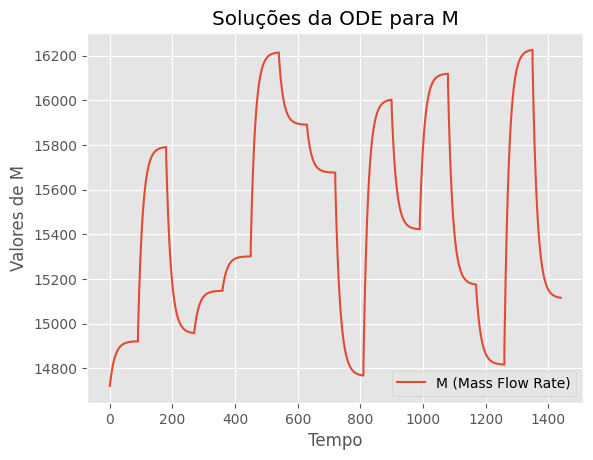

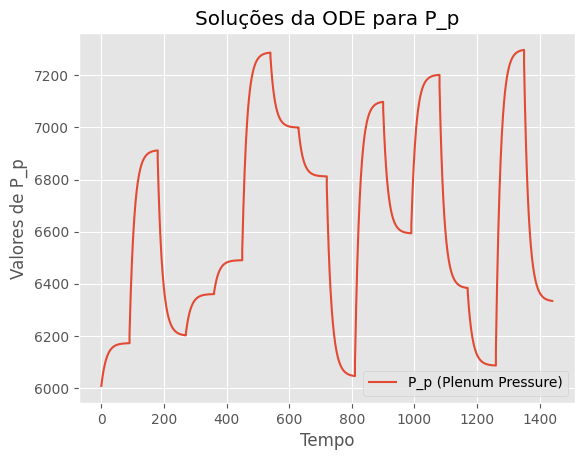

In [45]:

class P1Generator:
    def __init__(self, seed):
        np.random.seed(seed)
        self.generated_values = set()

    def P1(self):
        while True:
            value = np.random.uniform(4000, 5000)  # Corrigido para o intervalo desejado
            if value not in self.generated_values:
                self.generated_values.add(value)
                return value


def ale():
  return np.random.uniform(4000, 5000)



p1_gen = P1Generator(seed)

def Estacionario(X):
    x = X
  # Constantes
    A1 = 2.6e-3   # m²
    Lc = 2.0      # m
    alpha = 0.5   # 
    P_out = 5.0   # 
    C1 = 479.029  # Constante
    nu_P = 2.0    # m³
    K_nu = 0.38 *1000 # kg / (kBar^0.5 s)
    phi_value = 1.5   # φ
    z = 0 if x[1] < P_out else np.sqrt(x[1] - P_out)

    dmdt = (A1 / Lc) * (phi_value * 4000 - x[1])
    dPdt = ((C1**2) * (x[0] - alpha * K_nu * z)) / nu_P

    return dmdt, dPdt

stati = fsolve(Estacionario, [100000, 100000])

print(Estacionario(stati))

def Sistemas(x0, P1_value):
    x = MX.sym('x', 2)  #
    p = MX.sym('p')

    # Constantes
    A1 = 2.6e-3   # m²
    Lc = 2.0      # m
    alpha = 0.5   # 
    P_out = 5.0  # 
    C1 = 479.029  # Constante
    nu_P = 2.0    # m³
    K_nu = 0.38 *1000 # kg / (kBar^0.5 s)
    phi_value = 1.5  # φ

    z = if_else(x[1] < P_out, 0, sqrt(x[1] - P_out))
    
    star_time = time.time()
    rhs = vertcat(
        (A1 / Lc) * (phi_value * p - (x[1])),
        (C1**2) * (x[0] - alpha * K_nu * z)
    ) / nu_P

    ode = {'x': x, 'ode': rhs , 'p': p}
    
    F = integrator('F', 'cvodes', ode, {'tf': 90})

    #
    t_eval = np.linspace(0, 90, 120)
    sol = np.zeros((len(t_eval), 2))
    zeronum = 1e-9

    #
    
    for i in range(len(t_eval)):
        start = time.time()
        
        res = F(x0=x0, p=P1_value)
        x_next = res['xf'].full().flatten()
        sol[i] = x_next
        
        
        end = time.time()
        total = end - start
        print(f"Tempo de Cada Integração do Casadi", total )

        # Check for steady state
        if np.all(np.abs(x_next - x0) < zeronum):
            sol = sol[:i+1]
            t_eval = t_eval[:i+1]
            break
        # Update initial state
        x0 = x_next

    return sol, P1_value, t_eval

# Loop de geração de dados
def Loop(loops, stati):
    estados = []
    p1_total = []
    t_eval_total = []

    for i in range(loops):
        if i == 0:
            x0 = stati  # Inicializa com o estado estacionário
        else:
            x0 = estados[-1][-1]

        P1_v = p1_gen.P1()
        sol, P1_aleatorio, t_eval = Sistemas(x0, P1_v)
        estados.append(sol)
        p1_total.append(P1_aleatorio)

        # Tempo Total
        if i == 0:
            t_total = t_eval
        else:
            t_total = np.concatenate([t_total, t_total[-1] + t_eval])

    return estados, p1_total, t_total

aaaa, PlotP1, Plott = Loop(16, stati)
bbb = aaaa
Ploty = np.concatenate(aaaa)
M_final = Ploty[:, 0]
P_p_final = Ploty[:, 1]

# Plotar os resultados
plt.figure()
plt.plot(Plott, Ploty[:, 0], label='M (Mass Flow Rate)')
plt.xlabel('Tempo')
plt.ylabel('Valores de M')
plt.title('Soluções da ODE para M')
plt.legend()
plt.grid(True)

plt.figure()
plt.plot(Plott, Ploty[:, 1], label='P_p (Plenum Pressure)')
plt.xlabel('Tempo')
plt.ylabel('Valores de P_p')
plt.title('Soluções da ODE para P_p')
plt.legend()
plt.grid(True)
plt.show()




In [29]:

# Dados para treino
M_Ploty = np.vstack(bbb)
t_eval = np.hstack(Plott)
P1_values = np.array(PlotP1)
M = M_Ploty[:, 0]
P_p = M_Ploty[:, 1]

# Entradas e Saídas (Many to Many)
X = np.column_stack((M[:-1], P_p[:-1], np.repeat(P1_values, len(t_eval) // len(P1_values))[:len(M[:-1])]))
y = np.column_stack((M[1:], P_p[1:]))

split_index = len(X) // 2

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Padronizar Dados
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)


In [10]:

# Redimensionar as entradas para (batch_size, timesteps, features)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

# Função de objetivo para Optuna
def objective(trial):
    # Hiperparâmetros a serem otimizados
    n_units = trial.suggest_int('n_units', 50, 70)
    dropout_rate = trial.suggest_float('dropout_rate', 0.001, 0.05)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    
    # Construção do modelo
    model = keras.Sequential()
    model.add(layers.Bidirectional(layers.LSTM(n_units, return_sequences=False, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(2))

    # Configuração do otimizador
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    early_stopping = EarlyStopping(monitor='val_loss',
                                    patience=5,
                                    restore_best_weights=True)
    
    # Treinar o modelo
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=50,
                        batch_size=128,
                        verbose=0,
                        callbacks=[early_stopping])
    
    # Avaliar o modelo e retornar o valor da métrica que estamos otimizando
    val_loss = model.evaluate(X_test, y_test, verbose=0)

    return val_loss[0]


In [11]:



# Rodar a otimização com Optuna
study = optuna.create_study(direction='minimize')



[I 2024-10-24 02:00:14,736] A new study created in memory with name: no-name-fa137f82-279b-454f-85ce-805f0d5f189e


In [12]:

study.optimize(objective, n_trials=10)

# Imprimir o melhor conjunto de hiperparâmetros
print(study.best_params)



C:\Users\fabio\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2024-10-24 02:00:30,402] Trial 0 finished with value: 1.0654352903366089 and parameters: {'n_units': 61, 'dropout_rate': 0.04467482016320187, 'learning_rate': 1.237178735854654e-05}. Best is trial 0 with value: 1.0654352903366089.
[I 2024-10-24 02:00:44,684] Trial 1 finished with value: 0.00013769867655355483 and parameters: {'n_units': 64, 'dropout_rate': 0.006026506341105087, 'learning_rate': 0.0019532369421969473}. Best is trial 1 with value: 0.00013769867655355483.
[I 2024-10-24 02:00:58,496] Trial 2 finished with value: 0.03248298540711403 and parameters: {'n_units': 65, 'dropout_rate': 0.0056477508755721495, 'learning_rate': 0.0001472830144341771}. Best 

{'n_units': 64, 'dropout_rate': 0.006026506341105087, 'learning_rate': 0.0019532369421969473}


C:\Users\fabio\AppData\Local\Temp\ipykernel_26288\2999160266.py:1: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

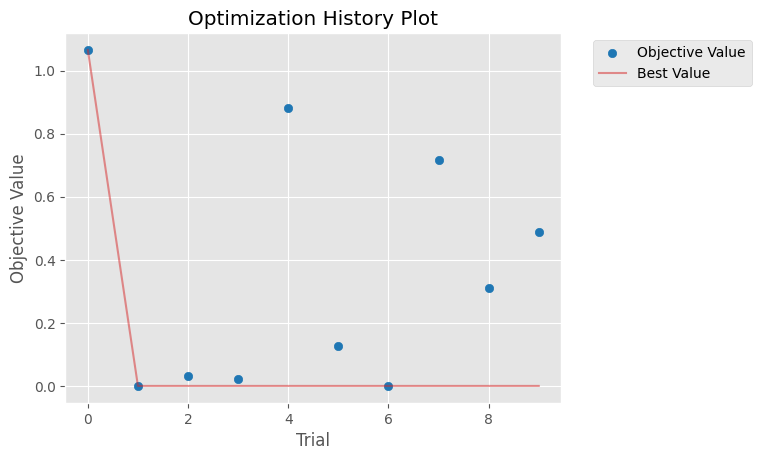

In [13]:
optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\fabio\AppData\Local\Temp\ipykernel_26288\82623574.py:1: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

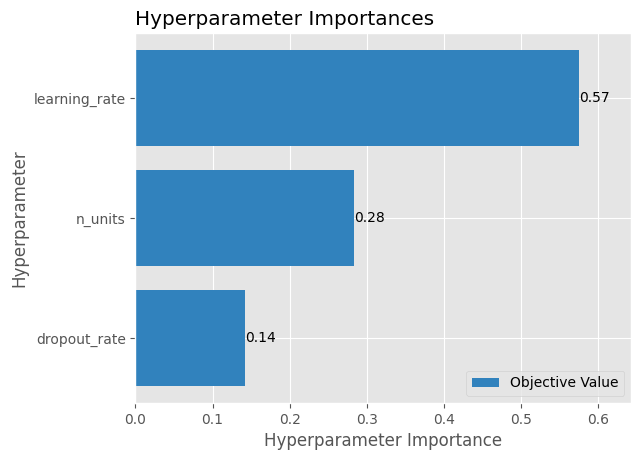

In [14]:
optuna.visualization.matplotlib.plot_param_importances(study)

In [15]:
# Treinar o modelo final com os melhores parâmetros
best_params = study.best_params



model = keras.Sequential()
model.add(layers.Bidirectional(layers.LSTM(best_params['n_units'], return_sequences=False, activation='tanh'), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(best_params['dropout_rate']))
model.add(layers.Dense(2))

optimizer = keras.optimizers.Adam(learning_rate=best_params['learning_rate'])



model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])



early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=50,
                    batch_size=128,
                    verbose=2,
                    #callbacks=[early_stopping]
                    )


Epoch 1/50


C:\Users\fabio\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 - 5s - 640ms/step - loss: 0.7130 - mae: 0.7628 - val_loss: 0.5410 - val_mae: 0.6393
Epoch 2/50
8/8 - 0s - 20ms/step - loss: 0.2856 - mae: 0.4754 - val_loss: 0.1393 - val_mae: 0.3138
Epoch 3/50
8/8 - 0s - 17ms/step - loss: 0.0481 - mae: 0.1687 - val_loss: 0.0477 - val_mae: 0.1706
Epoch 4/50
8/8 - 0s - 18ms/step - loss: 0.0322 - mae: 0.1449 - val_loss: 0.0719 - val_mae: 0.2450
Epoch 5/50
8/8 - 0s - 17ms/step - loss: 0.0258 - mae: 0.1234 - val_loss: 0.0346 - val_mae: 0.1276
Epoch 6/50
8/8 - 0s - 16ms/step - loss: 0.0131 - mae: 0.0739 - val_loss: 0.0322 - val_mae: 0.1218
Epoch 7/50
8/8 - 0s - 18ms/step - loss: 0.0132 - mae: 0.0783 - val_loss: 0.0292 - val_mae: 0.1140
Epoch 8/50
8/8 - 0s - 18ms/step - loss: 0.0104 - mae: 0.0625 - val_loss: 0.0280 - val_mae: 0.1097
Epoch 9/50
8/8 - 0s - 19ms/step - loss: 0.0097 - mae: 0.0576 - val_loss: 0.0265 - val_mae: 0.1056
Epoch 10/50
8/8 - 0s - 17ms/step - loss: 0.0091 - mae: 0.0550 - val_loss: 0.0245 - val_mae: 0.1019
Epoch 11/50
8/8 - 0s - 17ms/s

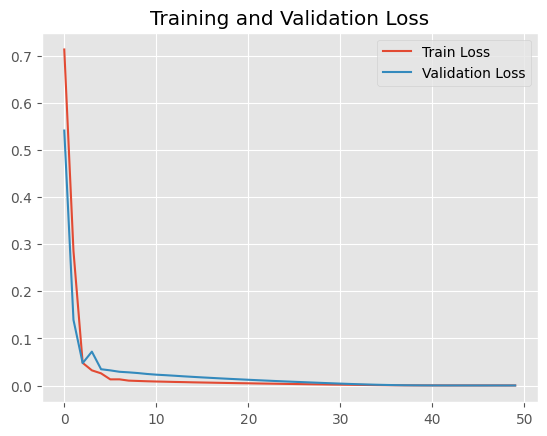

In [16]:

# Plotar a perda de treinamento e validação
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Ultimo P1: 4540.034464181656
Valores P1:[4115.054566389779, 4609.066539279482, 4133.390964185988, 4240.589619965349, 4327.13905581114, 4859.137490948598, 4666.090213098026, 4541.162212283403, 4029.0138244243603, 4733.748296280283, 4394.950018431005, 4802.047118628667, 4254.421125859879, 4056.8849366511517, 4866.6486408992005, 4221.028995884371]
1/1 - 0s - 40ms/step
1/1 - 0s - 32ms/step
1/1 - 0s - 33ms/step
1/1 - 0s - 48ms/step
1/1 - 0s - 48ms/step
1/1 - 0s - 48ms/step
1/1 - 0s - 50ms/step
1/1 - 0s - 60ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 48ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 42ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 32ms/step
1/1 - 0s - 46ms/step
1/1 - 0s - 32ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 48ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 39ms/step
1/1 - 0s - 41ms/step
1/1 - 0s - 48ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 48ms/step
1/1 - 0s - 40ms/step
1/1 - 0s - 43ms/step
1

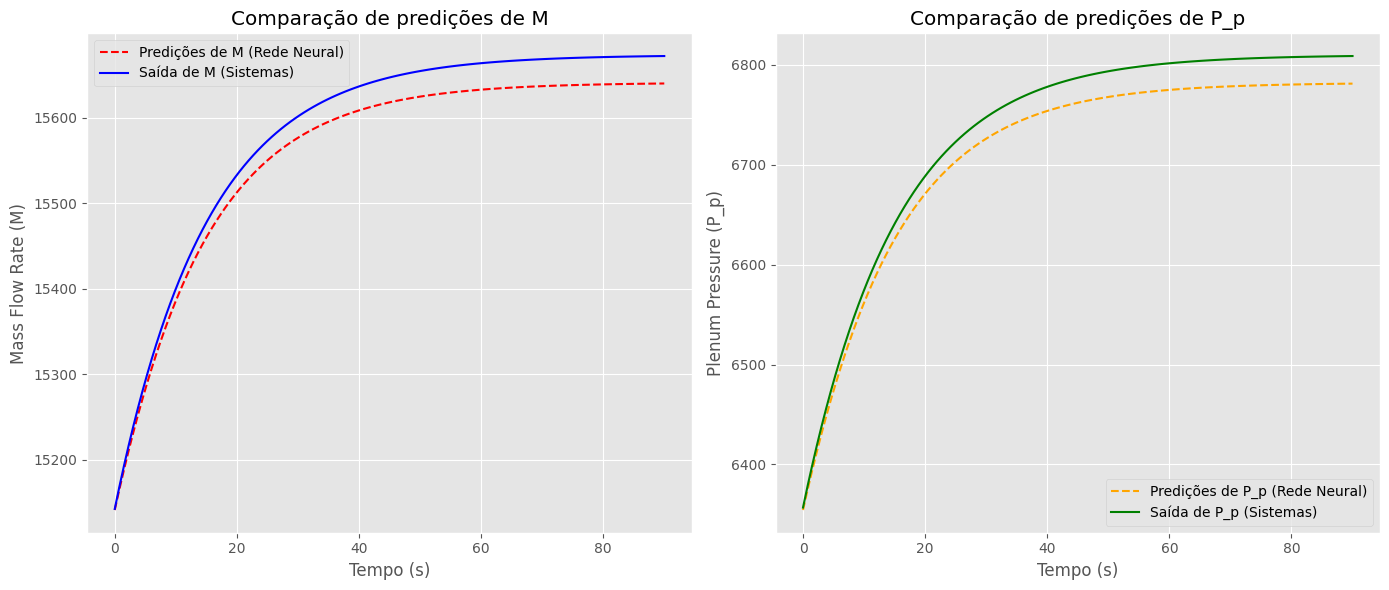

In [30]:
#Listas para armazenar as predições da rede neural
M_predicoes = []
P_p_predicoes = []

# Usar os últimos valores de M e P_p como ponto de partida
M_atual = M[-1]
P_p_atual = P_p[-1]
ultimo_P1 = p1_gen.P1()
print()
print(f"Ultimo P1: {ultimo_P1}")
print(f"Valores P1:{PlotP1}")
# Criar uma sequência de 360 pontos no intervalo de 0 a 30
t_eval = np.linspace(0, 90, 120)

# Iterar para gerar predições consecutivas correspondentes a 360 pontos
for _ in range(120):

    # Criar a entrada com o formato (M_atual, P_p_atual, ultimo_P1)
    entrada = np.array([[M_atual, P_p_atual, ultimo_P1]]) # The original error was caused because M_atual and P_p_atual were 1-D arrays
    entrada_normalizada = scaler_X.transform(entrada)

    # Realizar a predição
    predicao = model.predict(entrada_normalizada, verbose = 2)
    predicao_original = scaler_y.inverse_transform(predicao)

    # Extrair os valores preditos para M e P_p
    M_predito = predicao_original[0, 0]
    P_p_predito = predicao_original[0, 1]
    # Armazenar as predições
    M_predicoes.append(M_predito)
    P_p_predicoes.append(P_p_predito)

    # Atualizar os valores para a próxima iteração
    M_atual = M_predito
    P_p_atual = P_p_predito

# Gerar os valores de saída da função Sistemas
sol_sistemas, _, t_eval_sistemas = Sistemas([M[-1], P_p[-1]], ultimo_P1)
M_sistemas = sol_sistemas[:, 0]
P_p_sistemas = sol_sistemas[:, 1]

# Plotar as previsões e os valores de saída da função Sistemas
plt.figure(figsize=(14, 6))

# Plotagem do M
plt.subplot(1, 2, 1)
plt.plot(t_eval, M_predicoes, label='Predições de M (Rede Neural)', color='red', linestyle='--')
plt.plot(t_eval_sistemas, M_sistemas, label='Saída de M (Sistemas)', color='blue', linestyle='-')
plt.xlabel('Tempo (s)')
plt.ylabel('Mass Flow Rate (M)')
plt.title('Comparação de predições de M')
plt.legend()
plt.grid(True)

# Plotagem do P_p
plt.subplot(1, 2, 2)
plt.plot(t_eval, P_p_predicoes, label='Predições de P_p (Rede Neural)', color='orange', linestyle='--')
plt.plot(t_eval_sistemas, P_p_sistemas, label='Saída de P_p (Sistemas)', color='green', linestyle='-')
plt.xlabel('Tempo (s)')
plt.ylabel('Plenum Pressure (P_p)')
plt.title('Comparação de predições de P_p')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [35]:
X_test.shape #960 3 
#y_test #960 2 

(960, 3)

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


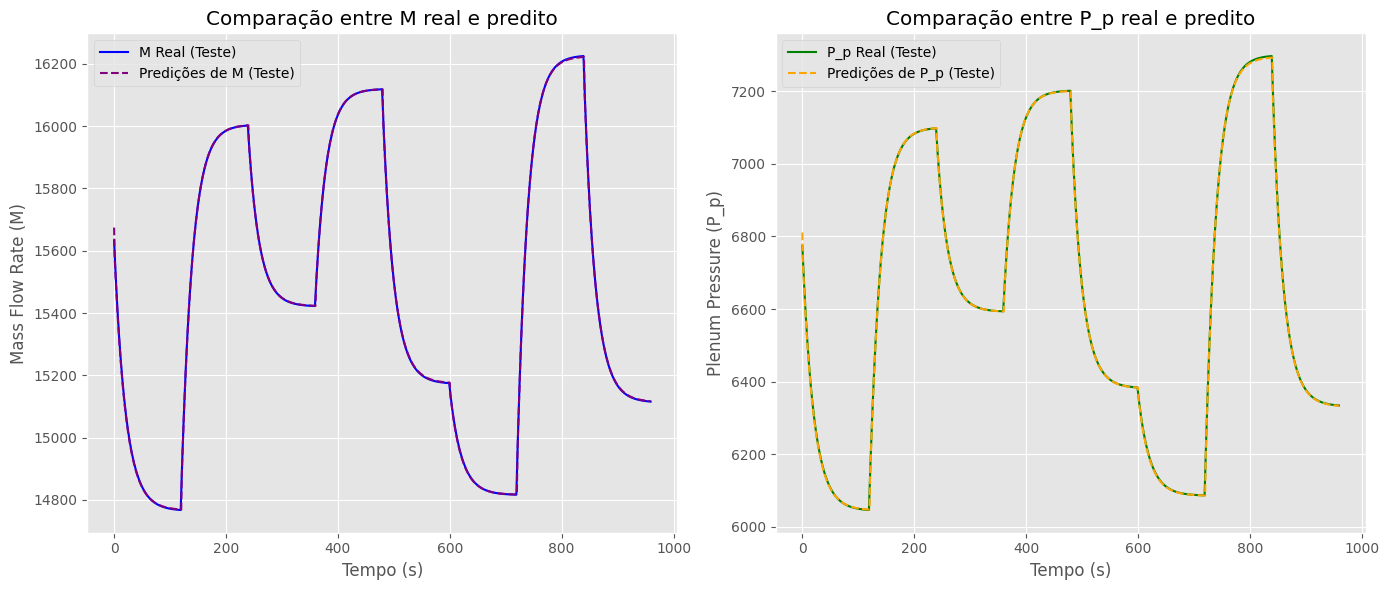

In [42]:
# Separar os dados de entrada (X_test) e as saídas reais (y_test)
rename_X = X_test.reshape(-1,3)  # Dados de entrada padronizadas (X_test)
rename_y = y_test.reshape(-1,2) # Saídas reais padronizadas (y_test)

# 1. Prever os valores de saída usando o modelo treinado (predições padronizadas)
y_test_pred = model.predict(rename_X)

# 2. despadronizadas as predições (y_test_pred) e os dados reais (rename_y)
y_test_pred_des = scaler_y.inverse_transform(y_test_pred)  # Previsões despadronizadas
y_test_real_des = scaler_y.inverse_transform(rename_y)  # Saídas reais despadronizadas

# 3. Separar as colunas de saídas reais (M e P_p)
M_real = y_test_real_des[:, 0]  # 
P_p_real = y_test_real_des[:, 1]  

# 4. Separar as colunas de predições (M e P_p preditos)
M_test_pred = y_test_pred_des[:, 0]  #
P_p_test_pred = y_test_pred_des[:, 1]  # 


t_eval_test = np.linspace(0, len(M_test_pred) - 1, len(M_test_pred))



plt.figure(figsize=(14, 6))

# Plot para M (Mass Flow Rate)
plt.subplot(1, 2, 1)
plt.plot(t_eval_test, M_real, label='M Real (Teste)', color='blue', linestyle='-')  # Saída real de M
plt.plot(t_eval_test, M_test_pred, label='Predições de M (Teste)', color='purple', linestyle='--')  # Predições de M
plt.xlabel('Tempo (s)')
plt.ylabel('Mass Flow Rate (M)')
plt.title('Comparação entre M real e predito')
plt.legend()
plt.grid(True)

# Plot para P_p (Plenum Pressure)
plt.subplot(1, 2, 2)
plt.plot(t_eval_test, P_p_real, label='P_p Real (Teste)', color='green', linestyle='-')  # Saída real de P_p
plt.plot(t_eval_test, P_p_test_pred, label='Predições de P_p (Teste)', color='orange', linestyle='--')  # Predições de P_p
plt.xlabel('Tempo (s)')
plt.ylabel('Plenum Pressure (P_p)')
plt.title('Comparação entre P_p real e predito')
plt.legend()
plt.grid(True)

# Ajustar o layout e mostrar o gráfico
plt.tight_layout()
plt.show()

In [40]:
rename_X.shape

(960, 3)